#**Image Gender Detection using Transfer Learning**

**By:** Shriya Haral



# **What is Gender Recognition ?**

Gender Recognition from images helps us to classify the images based on the gender i.e. whether the image is of a male or a female. 
For the classification of the image here we are using CelebA Dataset and model is implemented using Inception v3.

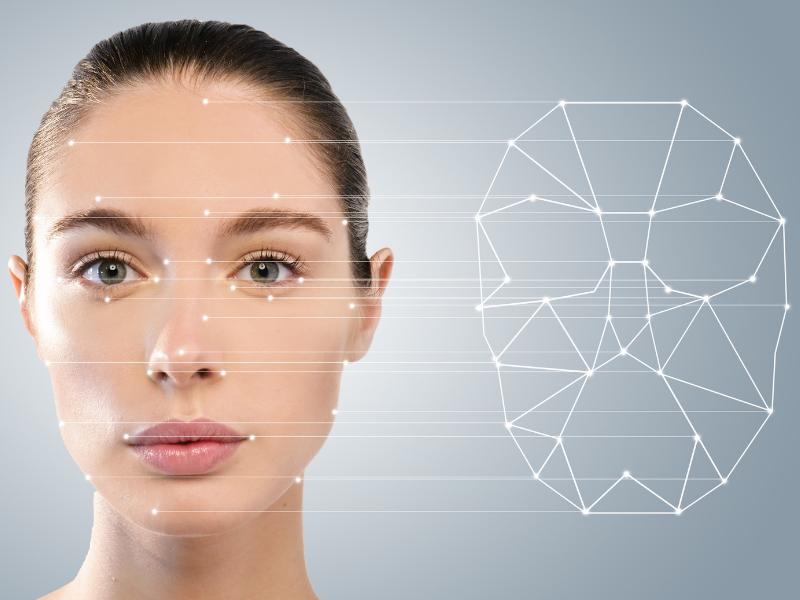

# **Methodology:**

**1. Importing libraries and fetching dataset from kaggle and google drive:**
*   Importing desired libraries.
*   Fetching Dataset from kaggle and mounting it on google drive.

**2.  Dataset:**
*   Dataset Description
*   Defining variables 
*   Reading Dataset 
*   Visualizing the dataset 
*   Partitions into train valid and test
*   Merging partitions
*   Creating dataframes for train test and valid

**3.   Data Augmentation:**
*    Data Augmentation on sample data
*   Creating Train and valid data generators 

**4.    Model Building:**
*   Importing Inception v3 model
*   Adding custom layers
*   Compiling the model 
*  Training the model

**5. Plots:**
* Loss Function 
* Accuracy 

**6. Evaluation:**
* Generating predictions on Test Data
* Evaluating the model 
* Predictions on new data 

**7. Predictions**
* Generating predictions
* Displaying random outputs

**8.Conclusion**

**References**


#**1.Import Libraries and fetching dataset from Kaggle**

**i) Importing libraries**

In [ ]:
import os #provides functions for interacting with the operating system.
import pandas as pd #allows various data manipulation operations such as merging, reshaping, selecting, as well as data cleaning, and data wrangling features.
import numpy as np #makes many mathematical operations used widely in scientific computing fast and easy to use
import cv2    #Open Cv
import matplotlib.pyplot as plt #creates a figure, creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc
import seaborn as sns #helps you explore and understand your data
from sklearn.metrics import f1_score #Compute the F1 score, also known as balanced F-score or F-measure.
from sklearn.metrics import accuracy_score #this function computes subset accuracy

from keras.applications.inception_v3 import InceptionV3, preprocess_input #For Inception v3 
from keras import optimizers #For optimizers
from keras.models import Sequential, Model #Models
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D #Layers
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img  #for ImageDataGeneration 
from keras.utils import np_utils
from keras.preprocessing import image 

from IPython.core.display import display, HTML #For HTML
from PIL import Image #python interpreter with image editing capabilities  
from io import BytesIO #methods that manipulate string and bytes data in memory
import base64 #used to encode and decode data

import tensorflow as tf #Tensorflow library 
print(f"Built using tensorflow version {tf.__version__}")

Built using tensorflow version 2.6.0


In [ ]:
%matplotlib inline

**ii) Fetching dataset from kaggle and mount it on google drive**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


You can download dataset from Kaggle
(https://www.kaggle.com/jessicali9530/celeba-dataset):

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip /content/celeba-dataset.zip

Archive:  /content/celeba-dataset.zip
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace img_align_celeba/img_align_celeba/000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **2. Dataset**

**i)Dataset Description:** 


*   **img_align_celeba.zip:** All the face images, cropped and aligned
*   **list_eval_partition.csv:** Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
*  **list_bbox_celeba.csv:** Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
*   **list_landmarks_align_celeba.csv:** Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
* **list_attr_celeba.csv:** Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

The dataset contains:
- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

**ii) Define Variables**

Set the main folder, images folder, image width, image height and other training parameters.

In [ ]:
# set variables 
main_folder = "/content/gdrive/MyDrive/Kaggle"
images_folder = os.path.join(main_folder, 'img_align_celeba', 'img_align_celeba')

IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 128
NUM_EPOCHS = 10

**iii) Read dataset**

Read Dataset and display data in readable format.
* '1' denotes feature is present
* '-1' denotes the feature is not present

Here, after reading the 'list_attr_celeba.csv', all the values of column 'Male' is replaced by column name "gender" having values as Male(1) and Female(-1)  

In [ ]:
df_imgs = pd.read_csv('/content/gdrive/MyDrive/Kaggle/list_attr_celeba.csv')
df_imgs.replace(to_replace={"Male": -1}, value="Female", inplace=True)
df_imgs.replace(to_replace={"Male": 1}, value="Male", inplace=True)
df_imgs.rename(columns={"Male": "gender"}, inplace=True)
df_imgs.head() 

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,gender,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,Female,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,Female,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Male,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Female,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,Female,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**iv) Visualizing Data**

Displays the class distribution of 'gender' 

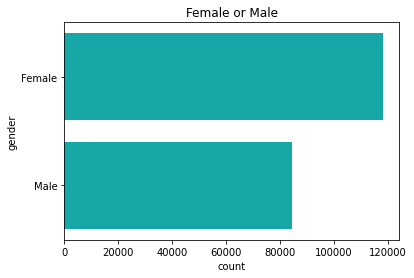

In [ ]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='gender', data=df_imgs, color="c")
plt.show()

The dataset is slightly imbalanced in gender class distribution.

**v) Data Partitioning into train, valid and test**

The dataset includes file 'list_eval_partition.csv' which provides us with the following partition:
- 0: train
- 1: valid
- 2: test

In [ ]:
df_partition = pd.read_csv('/content/gdrive/MyDrive/Kaggle/list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

**vi) Merging partition with labels on image_id**
- Joining partition and labels dataframe 
- Renaming image_id with the image path

In [ ]:
df_imgs = df_imgs.merge(df_partition, on="image_id")
df_imgs.loc[:, "image_id"] = df_imgs.loc[:, "image_id"].apply(lambda x: os.path.join(images_folder, x))
df_imgs.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,gender,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,/content/gdrive/MyDrive/Kaggle/img_align_celeb...,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,Female,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1,0
1,/content/gdrive/MyDrive/Kaggle/img_align_celeb...,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,Female,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,0
2,/content/gdrive/MyDrive/Kaggle/img_align_celeb...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Male,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,0
3,/content/gdrive/MyDrive/Kaggle/img_align_celeb...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,Female,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1,0
4,/content/gdrive/MyDrive/Kaggle/img_align_celeb...,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,Female,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,0


**vii) Creating the train, valid and test dataframes**
Train, Valid and Test dataframes will contain 2 features.i.e  
image_id and the label ("Male" or "Female")

In [ ]:
df_train = df_imgs.loc[df_imgs.loc[:, "partition"] == 0, 
                      ["image_id", "gender"]]
df_valid = df_imgs.loc[df_imgs.loc[:, "partition"] == 1, 
                      ["image_id", "gender"]]
df_test = df_imgs.loc[df_imgs.loc[:, "partition"] == 2, 
                      ["image_id", "gender"]]

#**3. Data Augmentation**
Using the image data generator and flow_from_dataframe methods to load images from a dataframe

Keras ImageDataGenerator and flow_from_dataframe is used to avoid loading all images in memory and fit the model on the entire dataset.


**i) Generating Image generator for data augmentation**

**Image Data Generator:** The generator will run through your image data and apply random transformations to each individual image as it is passed to the model so that it never sees the exact same image twice during training. These transformations are parameters on the generator that can be set when instantiated and can include rotations, shears, flips, and zooms. The benefit here is that the model will become more robust as it trains on images that are slightly distorted, and it helps to prevent the model from learning noise in your data such as where features are located in the image.

Found 1 validated image filenames.
Label: ['Female']


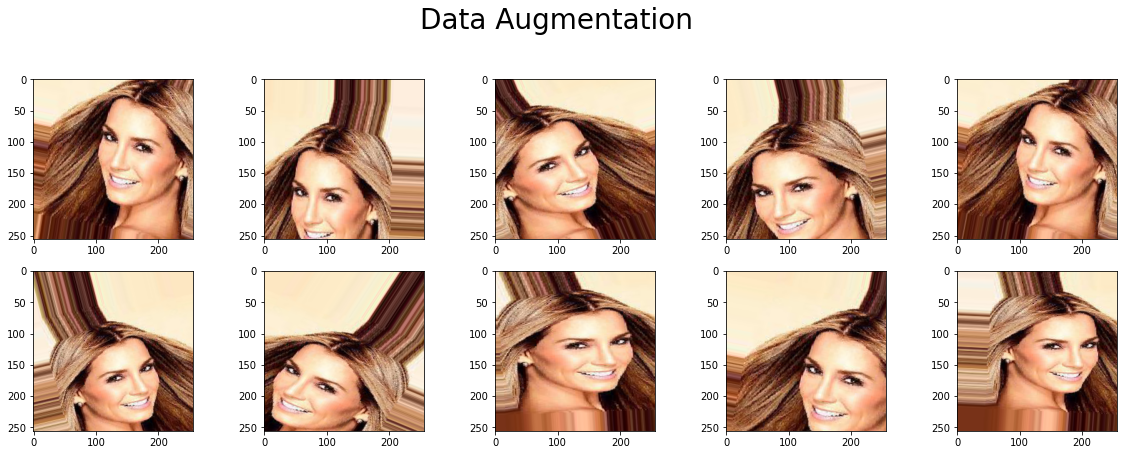

In [ ]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  rescale=1./255,
    
)

# load one image and reshape
def display_image(img: pd.DataFrame) -> None:
    
    # plot 10 augmented images of the loaded image
    plt.figure(figsize=(20,10))
    plt.suptitle('Data Augmentation', fontsize=28)

    i = 0
    for batch in datagen.flow_from_dataframe(img,
                                             batch_size=1,
                                             x_col="image_id", 
                                             y_col="gender",
                                             class_mode="raw",
                                             image_size=(IMG_WIDTH, IMG_HEIGHT)):
        batch_image = batch[0]
        batch_label = batch[1]
        plt.subplot(3, 5, i+1)
        plt.grid(False)
        plt.imshow(batch_image.reshape(256,256, 3))
        
        if i == 9:
            break
        i += 1
    print(f"Label: {batch_label}")
    plt.show()

display_image(df_imgs.loc[:0, :])

**ii) Creating Train and Validation data generators**

#####**Train Data Generators**

In [ ]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  #brightness_range=[0.4,1.5],
  rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    batch_size=20,
    x_col="image_id", 
    y_col="gender",
    class_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    validate_filenames=False)

Found 162770 non-validated image filenames belonging to 2 classes.


##### **Test Data Generators**

In [ ]:
valid_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
)

valid_generator = valid_datagen.flow_from_dataframe(
    df_valid,
    batch_size=20,
    x_col="image_id", 
    y_col="gender",
    class_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    validate_filenames=False)

Found 19867 non-validated image filenames belonging to 2 classes.


#**4. Model Building**

**i) Importing InceptionV3 Model**

#### Inception-V3 model structure
This is the structure of the Inception-V3 model, developed over the imagenet dataset.


<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>
source: https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png

The top layers (including classification) are not included.

### **Inception V3**

Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge.

The inception model (https://keras.io/api/applications/inceptionv3/) is available from Keras. We can either download pre-trained model or else can connect the notebook with the dataset using  "imagenet" as weights. 

#### Using Inception V3 model
I am using a pretrained Inception V3 model for which I will retrain some layers and fix the first layers. I will also attach new output layers to perform the new classification task. 

In [ ]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
# Lock initial layers to do not be trained
for layer in inc_model.layers[:52]:
    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step
number of layers: 311


**ii) Adding custom Layers**

Layers to be trained with the new model.

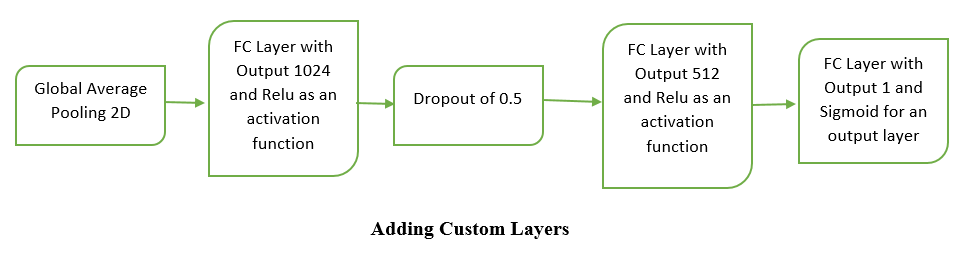

In [ ]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

**iii) Final model for training** 

In [ ]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# compile the model
model_.compile(optimizer="adam", 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

#### Making sure to use the best model from training according to its performance on the valid set

**iv) Model Check Point**

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

Reference Link: https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
#ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

**v) Training the model**

In [ ]:
hist = model_.fit(train_generator,
                  validation_data=valid_generator,
                  steps_per_epoch=len(df_train)//BATCH_SIZE,
                  validation_steps=len(df_valid) // BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  callbacks=[checkpointer],
                  verbose=1
                    )

Epoch 1/10
1271/1271 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8221
Epoch 00001: val_loss improved from inf to 0.23832, saving model to weights.best.inc.male.hdf5
1271/1271 [==============================] - 645s 507ms/step - loss: 0.3862 - accuracy: 0.8221 - val_loss: 0.2383 - val_accuracy: 0.9000
Epoch 2/10
1271/1271 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9185
Epoch 00002: val_loss improved from 0.23832 to 0.10064, saving model to weights.best.inc.male.hdf5
1271/1271 [==============================] - 611s 481ms/step - loss: 0.2053 - accuracy: 0.9185 - val_loss: 0.1006 - val_accuracy: 0.9587
Epoch 3/10
1271/1271 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9319
Epoch 00003: val_loss did not improve from 0.10064
1271/1271 [==============================] - 588s 463ms/step - loss: 0.1743 - accuracy: 0.9319 - val_loss: 0.1127 - val_accuracy: 0.9568
Epoch 4/10
1271/1271 [============================

# **5. Plots** 

**i) Loss function**

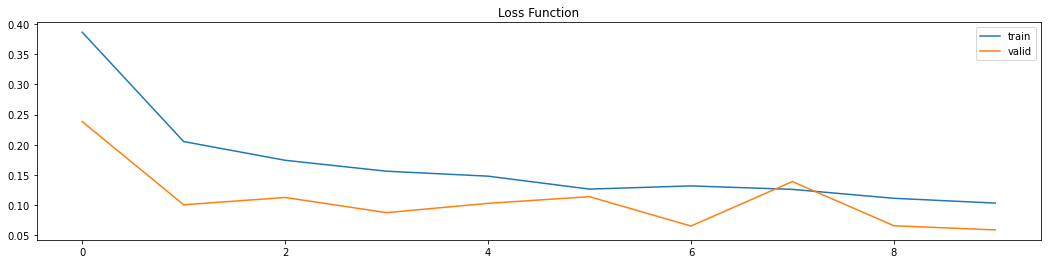

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

**ii) Accuracy**

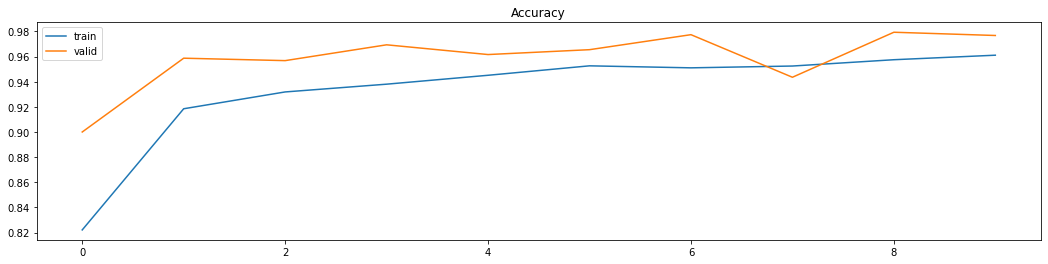

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

#### Select and use the best model from training according to the validation set

In [ ]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

# **6. Evaluation**

**i) Generating predictions on Test data**

In [ ]:
test_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    batch_size=20,
    x_col="image_id", 
    y_col="gender",
    class_mode="raw",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


In [ ]:
# generate prediction
model_predictions = model_.predict(test_generator, steps=len(df_test))

**ii) Model Evaluation**

In [ ]:
# report test accuracy
preds = np.array(model_predictions > 0.5).astype(int)
test_accuracy = 100 * accuracy_score(preds, df_test.loc[:, "gender"].replace({"Male": 1, "Female": 0}).values)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(df_test.loc[:, "gender"].replace({"Male": 1, "Female": 0}).values, preds))

Model Evaluation
Test accuracy: 96.9141%
f1_score: 0.9599271402550091


# **7. Predictions**

**i) Generating new predictions**

In [ ]:
def read_image(path: str) -> np.ndarray:
    # predicting images
    img = image.load_img(path, target_size=(256, 256))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.vstack([img])
    img = preprocess_input(img) # preprocess for our model input
    return img / 255.


def img_to_display(filename: str):
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename: str, target: str) -> None:
    """
    Display the results in HTML
    
    :param filename: path to the image
    :param target: real label from that image
    """
    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
    
    prediction = model_.predict(read_image(filename), steps=1).reshape(-1)
    
        
    if prediction <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
        prediction = 1 - prediction
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(np.round(max(prediction)*100,2))
               , target
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

**ii) Displaying random ouputs**


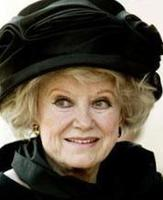


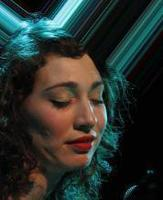


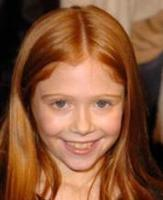


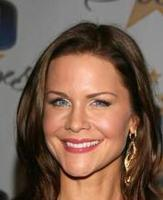


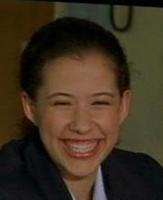


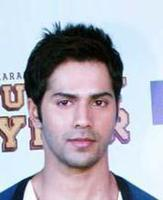


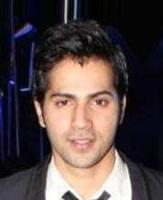


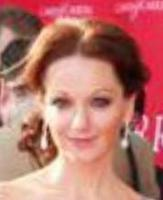


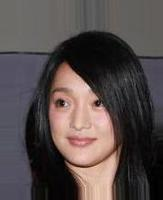


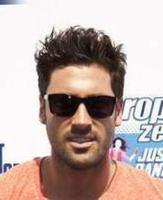

In [ ]:
#select random images of the test partition
df_to_test = df_test.iloc[: 10, :]

for _, row in df_to_test.iterrows():
    display_result(row["image_id"], row["gender"])

In [ ]:
model_.save("test_model_save.h5")

Additional code: batch prediction with flow from dataframe

In [ ]:
def predict(img: pd.DataFrame) -> np.ndarray:
    """
    @param img: pandas DataFrame containing the image paths under image_id
    
    :return: numpy array with boolean predictions.
    """
    datagen =  ImageDataGenerator(
      rescale=1./255,
      preprocessing_function=preprocess_input,

    )

    generator = datagen.flow_from_dataframe(img,
                                            suffle=False,
                                            batch_size=len(img),
                                            x_col="image_id", 
                                            class_mode=None,
                                            image_size=(IMG_WIDTH, IMG_HEIGHT))
    return model_.predict(generator, steps=len(img))

predict(df_imgs.loc[:10]) >= 0.5

Found 11 validated image filenames.


array([[False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False]])

# **8. Conclusion:**
 
In this way, I have implemented Image Gender Detection using Transfer Learning (Inception v3). 
The built model using transfer learning from the InceptionV3 and adding custom layers successfully recognize the gender giving certain picture with **96.91%** of accuracy over the test data.
As the dataset was huge, I had directly imported it from kaggle using API command of the dataset with the help of Google Drive. 

# **References:**
1. https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a 

2. https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf 

3. https://medium.com/swlh/gender-classifier-with-tensorflow-164b62a3557e 

4. https://www.oreilly.com/library/view/neural-networks-with/9781789346640/63f97f70-7449-4828-ac80-fe7b9682becf.xhtml 

5. https://www.ijcseonline.org/pub_paper/114-IJCSE-06372.pdf 